In [1]:
import json
import os
import warnings
from pathlib import Path

from pprint import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# filepath = Path(__file__).parent
filepath = Path(os.path.abspath(''))
print(filepath)

canc_col_name = "improve_sample_id"
drug_col_name = "improve_chem_id"

/nfs/lambda_stor_01/data/apartin/projects/IMPROVE/pan-models/csa_postproc_all


In [2]:
main_models_path = filepath / 'models'  # dir containing the collection of models
models_paths_list  = sorted(main_models_path.glob('*'))  # list of paths to the models
models_paths_list[1]

PosixPath('/nfs/lambda_stor_01/data/apartin/projects/IMPROVE/pan-models/csa_postproc_all/models/GraphDRP')

In [4]:
# Aggregate runtimes from all models

res_fname = 'runtimes.csv'
out_fname = 'all_models_' + res_fname

agg_df_list = []
missing_files = []

for model_dir in models_paths_list:
    model_name = model_dir.name
    pp_res_path = model_dir / f"postproc.csa.{model_name}.improve_output"
    print(pp_res_path)
    try:
        rr = pd.read_csv(pp_res_path / res_fname, sep=',')
        agg_df_list.append(rr)
    except FileNotFoundError:
        warnings.warn(f"File not found! {pp_res_path}", UserWarning)
        missing_files.append(pp_res_path)

df = pd.concat(agg_df_list, axis=0)
df.to_csv(filepath / out_fname, index=False)
pprint(df.shape)
# pprint(df.nunique())
pprint(df[:3])

/nfs/lambda_stor_01/data/apartin/projects/IMPROVE/pan-models/csa_postproc_all/models/DeepCDR/postproc.csa.DeepCDR.improve_output
/nfs/lambda_stor_01/data/apartin/projects/IMPROVE/pan-models/csa_postproc_all/models/GraphDRP/postproc.csa.GraphDRP.improve_output
/nfs/lambda_stor_01/data/apartin/projects/IMPROVE/pan-models/csa_postproc_all/models/tCNNS/postproc.csa.tCNNS.improve_output
(1100, 9)
   hours  minutes    seconds   src   trg  split  tot_mins    model       stage
0      0        2  33.573939  CCLE  CCLE      0         2  DeepCDR  preprocess
1      0        2  32.301698  CCLE  CCLE      1         2  DeepCDR  preprocess
2      0        2  34.182968  CCLE  CCLE      2         2  DeepCDR  preprocess


/homes/apartin/miniconda3/envs/graphdrp_py37_improve/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: File not found! /nfs/lambda_stor_01/data/apartin/projects/IMPROVE/pan-models/csa_postproc_all/models/tCNNS/postproc.csa.tCNNS.improve_output
  app.launch_new_instance()


In [5]:
# Aggregate scores from all models

res_fname = 'all_scores.csv'
out_fname = 'all_models_' + res_fname

agg_df_list = []
missing_files = []

for model_dir in models_paths_list:
    model_name = model_dir.name
    pp_res_path = model_dir / f"postproc.csa.{model_name}.improve_output"
    print(pp_res_path)
    try:
        rr = pd.read_csv(pp_res_path / res_fname, sep=',')
        agg_df_list.append(rr)
    except FileNotFoundError:
        warnings.warn(f"File not found! {pp_res_path}", UserWarning)
        missing_files.append(pp_res_path)

df = pd.concat(agg_df_list, axis=0)
df.to_csv(filepath / out_fname, index=False)
pprint(df.shape)
# pprint(df.nunique())
pprint(df[:3])

/nfs/lambda_stor_01/data/apartin/projects/IMPROVE/pan-models/csa_postproc_all/models/DeepCDR/postproc.csa.DeepCDR.improve_output
/nfs/lambda_stor_01/data/apartin/projects/IMPROVE/pan-models/csa_postproc_all/models/GraphDRP/postproc.csa.GraphDRP.improve_output
/nfs/lambda_stor_01/data/apartin/projects/IMPROVE/pan-models/csa_postproc_all/models/tCNNS/postproc.csa.tCNNS.improve_output
(3750, 6)
   met  split     value   src   trg    model
0  mse      0  0.006245  CCLE  CCLE  DeepCDR
1  mse      1  0.006012  CCLE  CCLE  DeepCDR
2  mse      2  0.006210  CCLE  CCLE  DeepCDR


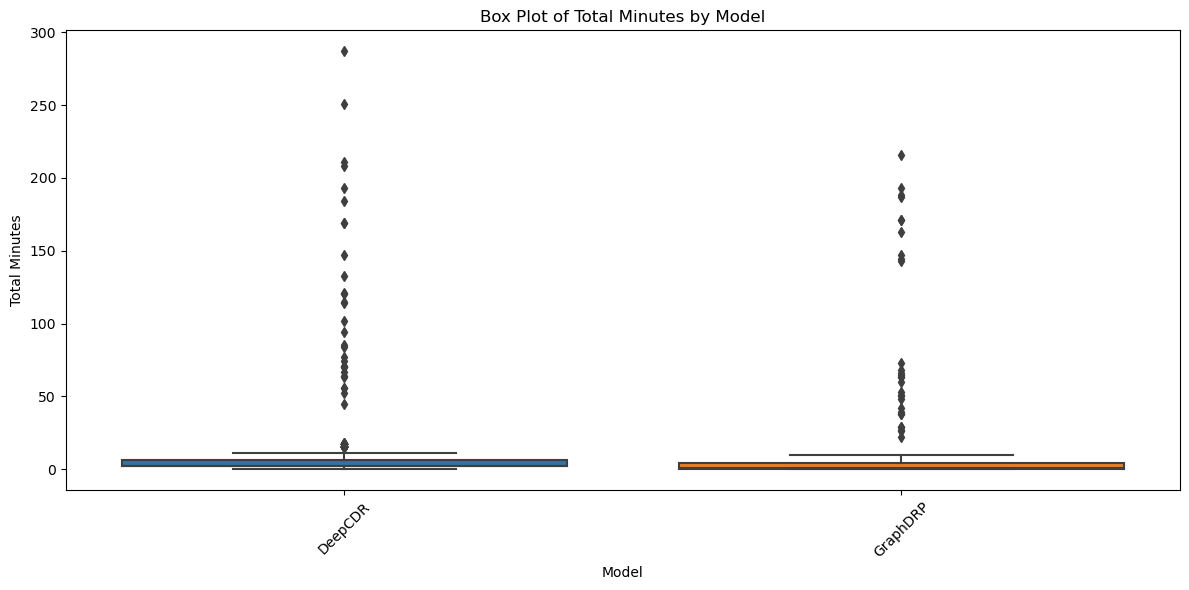

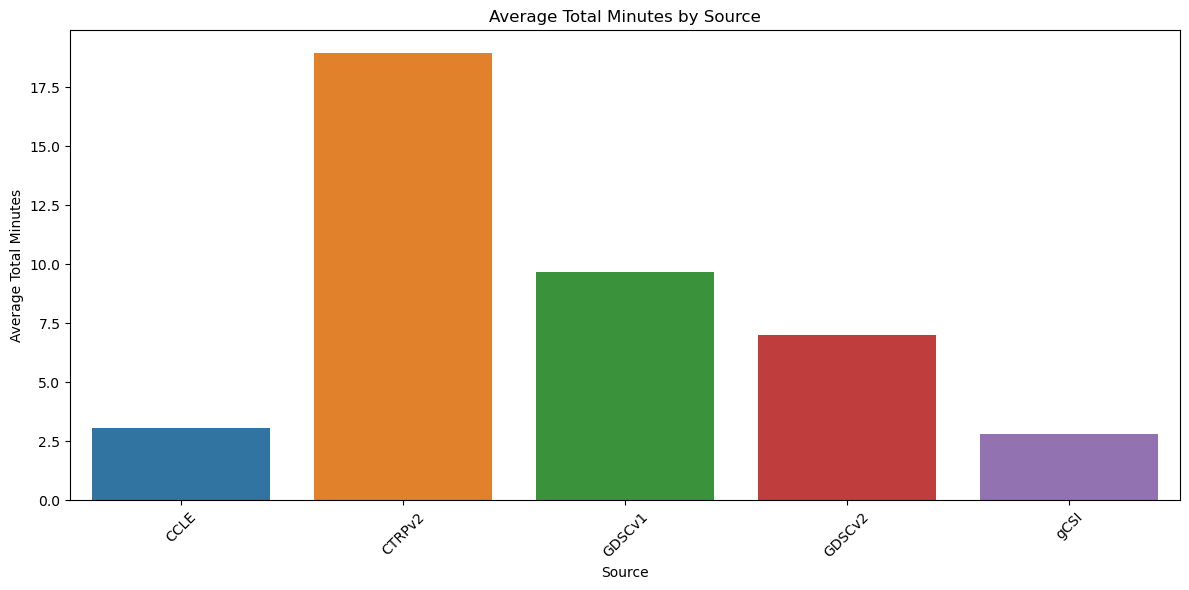

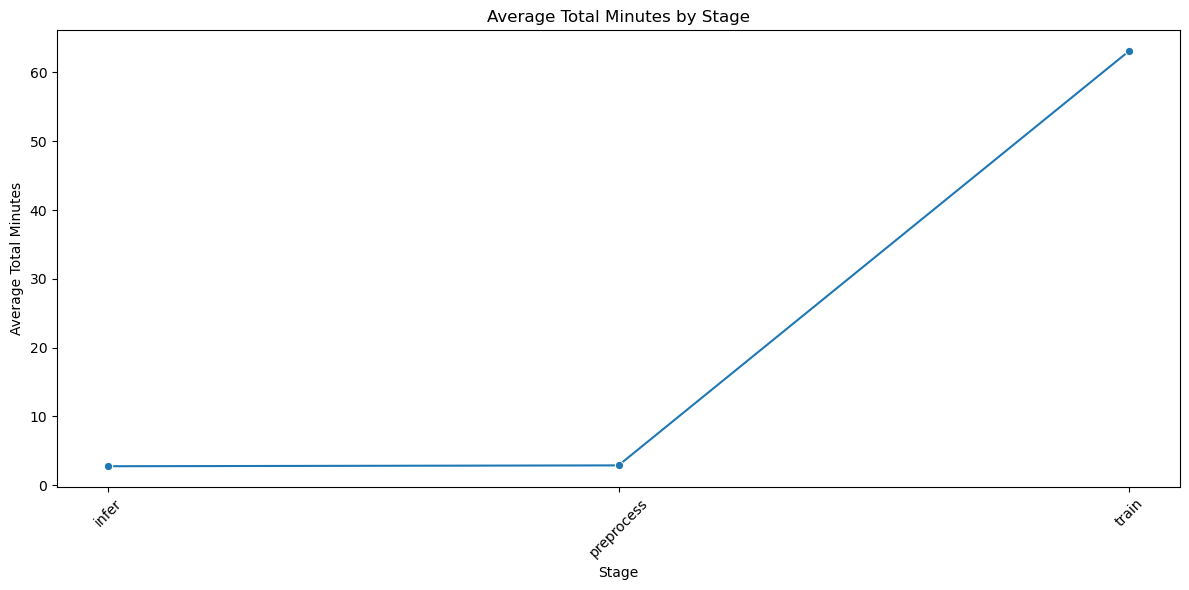

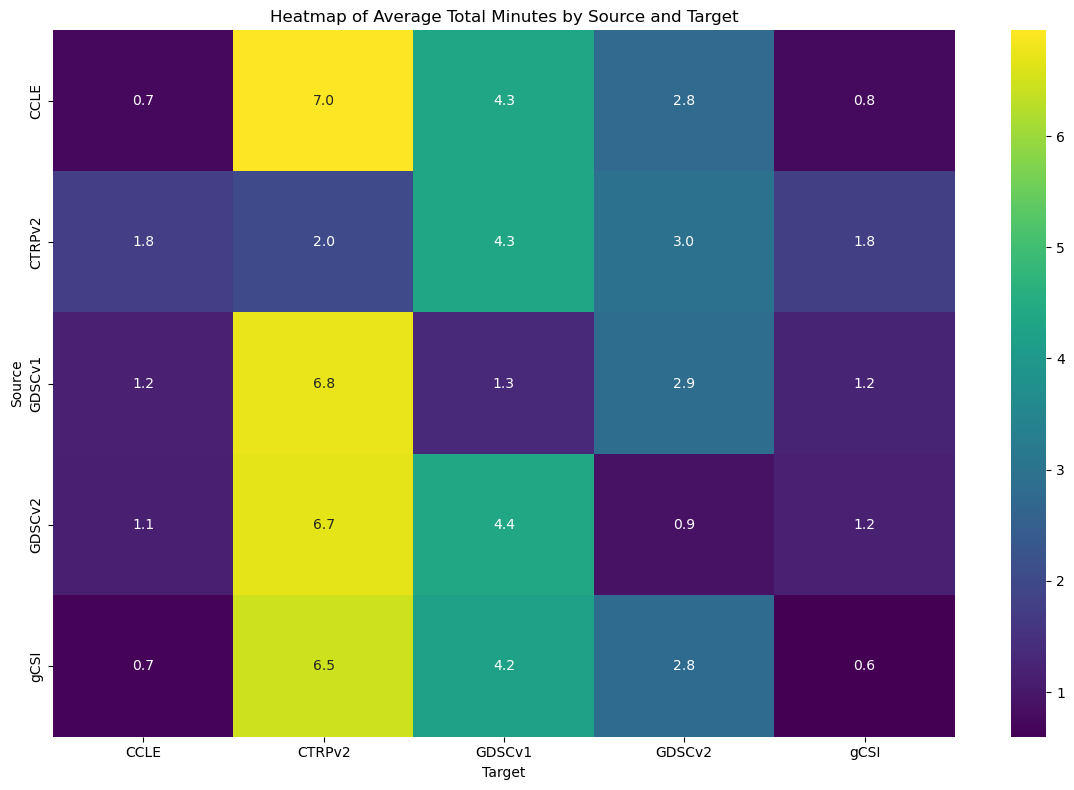

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('all_models_runtimes.csv')

# 1. Box Plot of Total Minutes by Model
plt.figure(figsize=(12, 6))
sns.boxplot(x='model', y='tot_mins', data=df)
plt.title('Box Plot of Total Minutes by Model')
plt.xticks(rotation=45)
plt.ylabel('Total Minutes')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

# 2. Bar Plot of Average Total Minutes by Source
avg_tot_mins_src = df.groupby('src')['tot_mins'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='src', y='tot_mins', data=avg_tot_mins_src)
plt.title('Average Total Minutes by Source')
plt.ylabel('Average Total Minutes')
plt.xlabel('Source')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Line Plot of Total Minutes by Stage
avg_tot_mins_stage = df.groupby('stage')['tot_mins'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='stage', y='tot_mins', data=avg_tot_mins_stage, marker='o')
plt.title('Average Total Minutes by Stage')
plt.ylabel('Average Total Minutes')
plt.xlabel('Stage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Heatmap of Total Minutes by Source and Target
heatmap_data = df.pivot_table(values='tot_mins', index='src', columns='trg', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='viridis')
plt.title('Heatmap of Average Total Minutes by Source and Target')
plt.ylabel('Source')
plt.xlabel('Target')
plt.tight_layout()
plt.show()

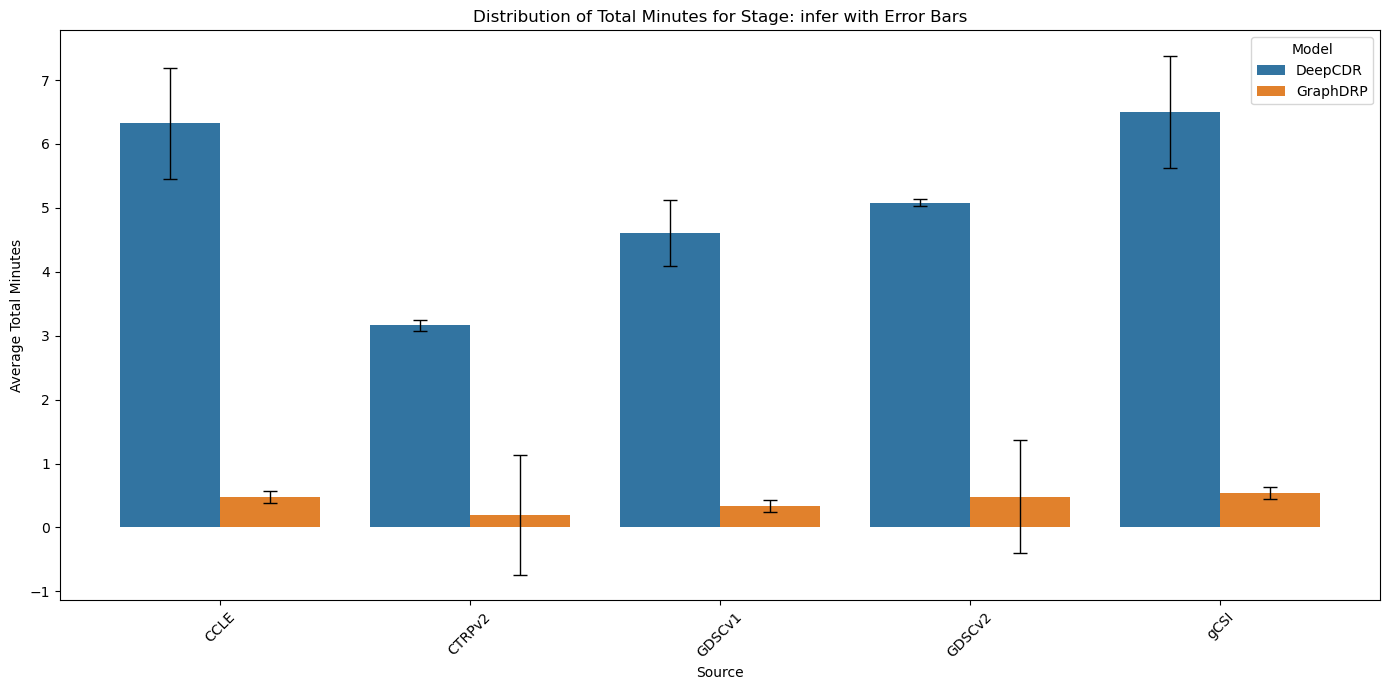

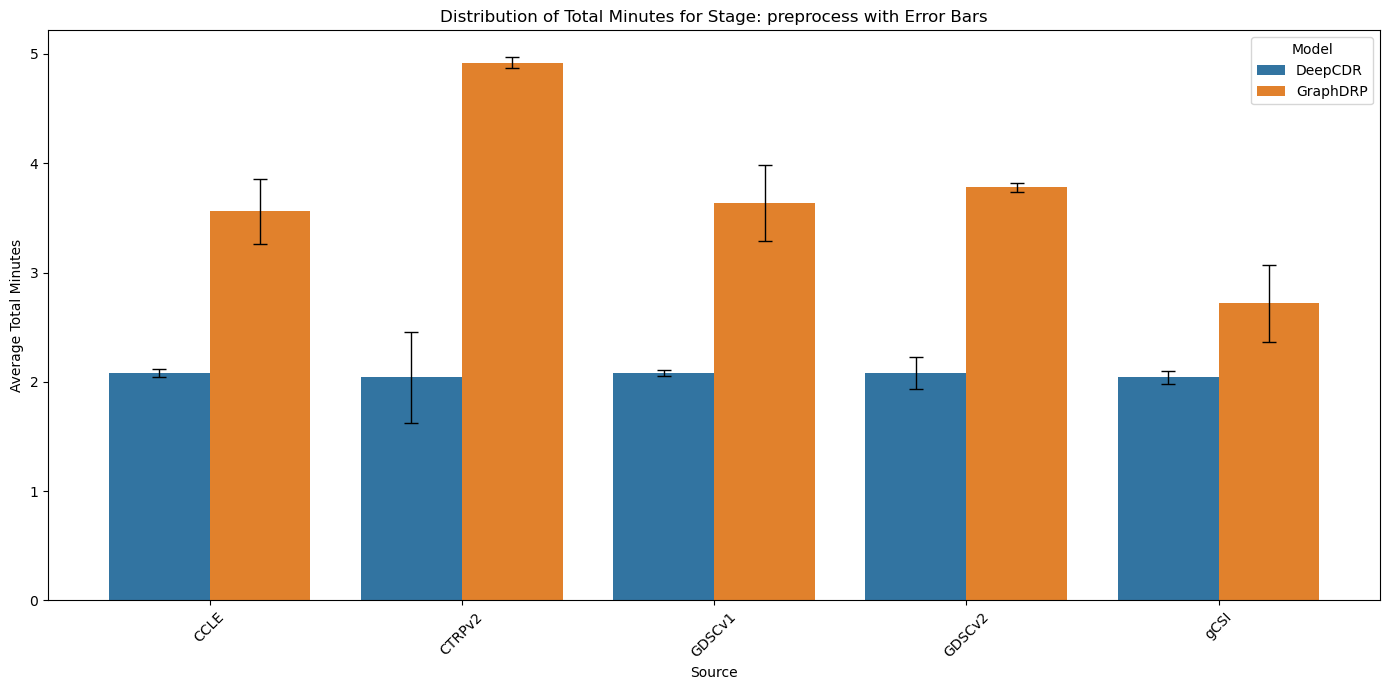

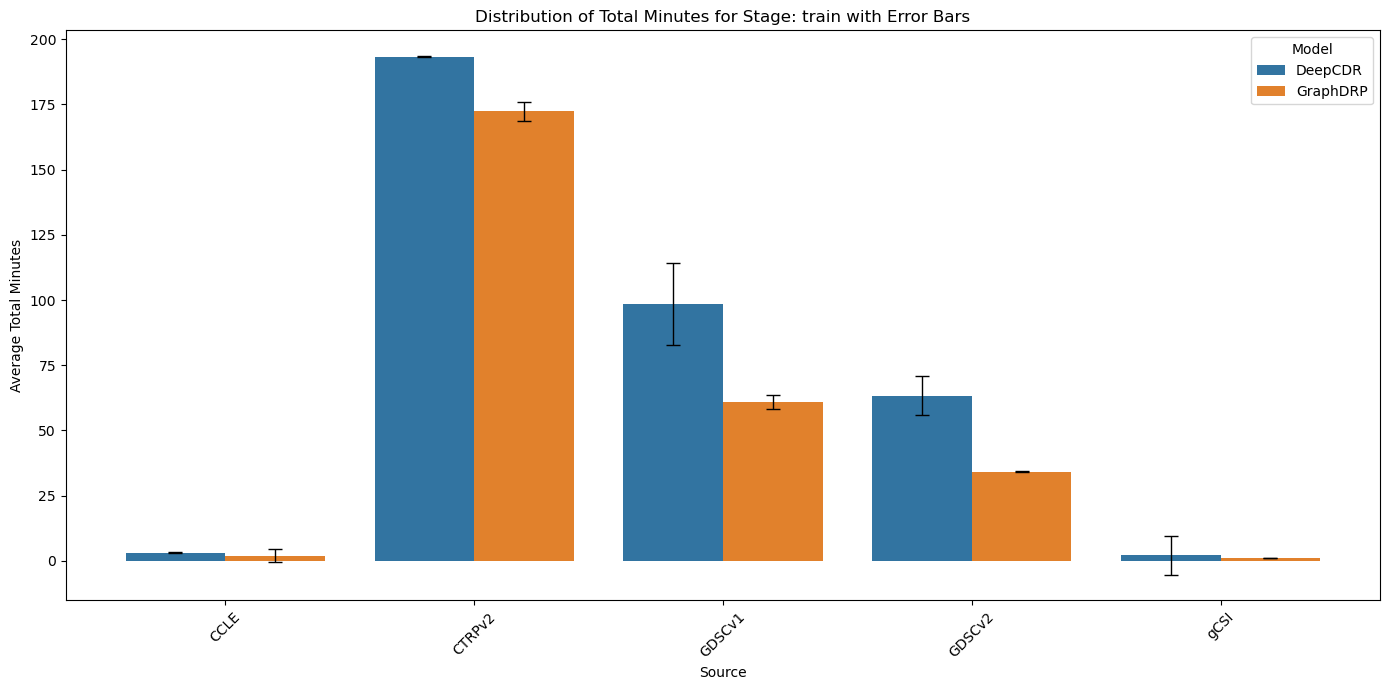

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('all_models_runtimes.csv')

# Group by src, stage, and model, and calculate the mean and standard deviation of tot_mins
stage_model_src_stats = df.groupby(['src', 'stage', 'model'])['tot_mins'].agg(['mean', 'std', 'count']).reset_index()

# Calculate the standard error of the mean (sem)
stage_model_src_stats['sem'] = stage_model_src_stats['std'] / stage_model_src_stats['count'] ** 0.5

# Define a color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create separate plots for each stage
stages = stage_model_src_stats['stage'].unique()

for stage in stages:
    plt.figure(figsize=(14, 7))
    stage_data = stage_model_src_stats[stage_model_src_stats['stage'] == stage]
    
    bar_plot = sns.barplot(x='src', y='mean', hue='model', data=stage_data, palette=colors, errorbar=None)
    
    # Add error bars for each bar
    for index, bar in enumerate(bar_plot.patches):
        height = bar.get_height()
        sem = stage_data['sem'].iloc[index]
        
        plt.errorbar(x=bar.get_x() + bar.get_width() / 2, 
                     y=height, 
                     yerr=sem, 
                     fmt='none', 
                     c='black', 
                     capsize=5, 
                     elinewidth=1)

    plt.title(f'Distribution of Total Minutes for Stage {stage} with Error Bars')
    plt.ylabel('Average Total Minutes')
    plt.xlabel('Source')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()